# Supercompressible (3d)

L. F. Pereira (lfpereira@fe.up.pt)\
September 7, 2020


This notebook creates the **design of experiments** and the metadata required to run the **numerical simulations**.

**Note**: the parametric `Abaqus` scripts were created using `F3DAS` implementations. You can also create your own functions and use them within this framework!

**TODO**: 
* add notebooks are not the best tool to run this (use script), but this intends to show how to use the tools.

Let's import the required libraries.

In [1]:
# imports

# standard library
import os
import pickle
from collections import OrderedDict

# third-party
import numpy as np
from SALib.sample import sobol_sequence
import pandas as pd
from matplotlib import pyplot as plt

# local library
from f3das.run.utils import create_main_file
from f3das.run.utils import create_sim_info
from f3das.run.utils import get_sims_info
from f3das.run.stats import analyze_times
from f3das.abaqus.run.utils import run_sims
from f3das.post_processing import post_process_sims
from f3das.post_processing import concatenate_data
from abaqus_modules.get_results import get_results

Now define the directory name and the number of points.

In [2]:
example_name = 'example_0'

n_pts = 10  # number of points

In [3]:
import shutil
try:
    shutil.rmtree(example_name)
except:
    pass

A quick verification of the chosen name will be performed to avoid overriding existing folders.

In [4]:
if os.path.exists(example_name):
    raise Exception('Name already exists')

## Introduction

**TODO**
* What is F3DAS?

## Design of experiments

Now, we need to define the problem.

Let's define the **variables of the problem**, both the variables that are defined by the design of experiments scheme and the fixed variables (i.e. the variables that are common for all simulations).

**Note**: the use of an ```OrderedDict``` is not mandatory, but forces variable order in the ```Pandas``` frame.

In [5]:
doe_variables = OrderedDict({'ratio_d': [0.004, 0.073],
                             'ratio_pitch': [.25, 1.5],
                             'ratio_top_diameter': [0., 0.8]})
fixed_variables = {'n_longerons': 3,
                   'bottom_diameter': 100.,
                   'young_modulus': 3500.,
                   'shear_modulus': 1287.,}

In [6]:
def transform_inputs_supercompressible(inputs):
    # initialization
    normalize_by_diameter = ['pitch', 'd']
    normalize_by_diameter_diff = ['top_diameter']
    
    # get new variables
    bottom_diameter = inputs['bottom_diameter']
    young_modulus = inputs['young_modulus']
    new_inputs = {}
    for var_name, variable in inputs.items():
        if var_name[0:5] == 'ratio':

            _, var_name = var_name.split('_', 1)
            if var_name in normalize_by_diameter:
                variable *= bottom_diameter
            elif var_name in normalize_by_diameter_diff:
                variable = bottom_diameter * (1 - variable)

        new_inputs[var_name] = variable
    
    return new_inputs

The supercompressible problem is *special*, in the way there's an additional variable that is not fixed nor controlled by the design of experiments scheme: **imperfections**.

In [7]:
seed = 1
deg2rad = np.pi / 180
m = 4. * deg2rad  # mean
s = 1.2 * deg2rad  # std
sigma = np.sqrt(np.log(s**2 / m**2 + 1))
mu = np.log((m**2) / np.sqrt(s**2 + m**2))
imperfection_dist = {'mean': mu, 'sigma': sigma}
imperfections = np.random.lognormal(size=n_pts, **imperfection_dist)

Another important step is the definition of the information related with the numerical simulations.

In [8]:
abstract_model = ['abaqus_modules.supercompressible_fnc.lin_buckle',
                  'abaqus_modules.supercompressible_fnc.riks']
# TODO: change name
sim_info = OrderedDict({'SUPERCOMPRESSIBLE_LIN_BUCKLE':
                        {'job_info': {'name': 'Simul_supercompressible_lin_buckle',
                                      'description': ''}},
                        'SUPERCOMPRESSIBLE_RIKS':
                        {'job_info': {'name': 'Simul_supercompressible_riks',
                                      'description': ''}}})
post_processing_fnc = ['abaqus_modules.supercompressible_fnc.post_process_lin_buckle',
                       'abaqus_modules.supercompressible_fnc.post_process_riks']

sim_info = create_sim_info(abstract_model=abstract_model, sim_info=sim_info,
                           post_processing_fnc=post_processing_fnc,
                           transform_inputs=transform_inputs_supercompressible)

In [9]:
print(sim_info)

{'abstract_model': ['abaqus_modules.supercompressible_fnc.lin_buckle', 'abaqus_modules.supercompressible_fnc.riks'], 'sim_info': OrderedDict([('SUPERCOMPRESSIBLE_LIN_BUCKLE', {'job_info': {'name': 'Simul_supercompressible_lin_buckle', 'description': ''}}), ('SUPERCOMPRESSIBLE_RIKS', {'job_info': {'name': 'Simul_supercompressible_riks', 'description': ''}})]), 'post_processing_fnc': ['abaqus_modules.supercompressible_fnc.post_process_lin_buckle', 'abaqus_modules.supercompressible_fnc.post_process_riks'], 'transform_inputs': <function transform_inputs_supercompressible at 0x0000015EFFE63EE0>}


The simulation definition is quite straightforward.

First, we need to define the `abstract_model`. That is, the class that is initialized given the variables values and contains all the methods required to successfully create, run and post-process the numerical model.

Second, we need to define the specific parameters of each simulation. In this example, there's a first simulation that performs a linear buckling analysis and another that performs a riks analysis. The second simulation depends on the results of the first. The use of an `OrderedDict` is of great importance to guarantee the right order of the simulations. `job_info` is the fundamental key and has to be always defined.

Finally, we define also a transformation of inputs. This is simply a mapping from the variables used in the design of experiments to the variables required to create the model.

Now, using a proper design of experiments scheme, we can create the design of experiments. Here, we simply use Sobol sequence implementation from ```SALib``` library.

In [10]:
dim = len(doe_variables)
points_sobol = sobol_sequence.sample(n_pts, dim)
for i, lims in enumerate(doe_variables.values()):
    points_sobol[:, i] = points_sobol[:, i] * (lims[1] - lims[0]) + lims[0]

Finally, we store the information in a dictionary and save it. Note the design of experiments is stored in a ```Pandas.DataFrame```. This is a convenient way for the subsequent application of Machine Learning.

In [11]:
doe_variables_ls = list(doe_variables.keys())
points = pd.DataFrame(points_sobol, columns=doe_variables_ls)
additional_variables = {'imperfection': imperfections}
additional_info = {'imperfection_dist': imperfection_dist,
                   'seed': seed}

In [12]:
create_main_file(example_name, doe_variables, points, sim_info,
                 fixed_variables=fixed_variables,
                 additional_variables=additional_variables,
                 additional_info=additional_info)

## Run simulations

First, let's open the created file and see what it contains.

In [14]:
with open(os.path.join(example_name, 'DoE.pkl'), 'rb') as file:
    data = pickle.load(file)
    
print(data.keys())

dict_keys(['doe_variables', 'points', 'sim_info', 'run_info', 'version', 'fixed_variables', 'additional_variables', 'additional_info'])


For the running step, the field `run_info` is of great importance, because it gives information about the simulations that are still missing or were already run (both successfully or with errors).

In [15]:
print(data['run_info'])

{'missing_sims': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'running_sims': [], 'error_sims': [], 'successful_sims': []}


During the running we can see simulations status using `get_sims_info` (it also works before and after).

In [16]:
get_sims_info(example_name)

Missing simulations (total): 10/10 (100.0%)


We run the simulations through `run_sims`. We can control the simulations we want to run or choose to run the first `n_sims`.

We can also use parallel computating to run several simulations simultaneously (only allowed if each simulation uses only one cpu). In that case, a `jupyter notebook` may not be the most appropriate tool because all the code has necessarily to be within the condition `if __name__ == '__main__'`. e.g.:
```python
from f3das.abaqus.run.utils import run_sims

if __name__ == '__main__':
    # (...)
    
    run_sims(example_name)
```

In [17]:
run_sims(example_name, points=[2], abaqus_path='abaqus',
         keep_odb=True, dump_py_objs=False, gui=False)

## Post-processing

After running the simulations, we collect data and store the quantities of interest in the `pandas.Dataframe` that contains the design of experiments. We have to provide a function that transforms the data collected during the simulations (contained in the key `'post-processing'`).

In [18]:
post_process_sims(pp_fnc=get_results,
                  output_variables=['coilable', 'sigma_crit', 'energy'],
                  example_name=example_name)

In [19]:
with open(os.path.join(example_name, 'DoE.pkl'), 'rb') as file:
    data = pickle.load(file)
    
print(data['points'])

    ratio_d  ratio_pitch  ratio_top_diameter coilable sigma_crit   energy
0  0.004000     0.250000                0.00     None       None     None
1  0.038500     0.875000                0.40     None       None     None
2  0.055750     0.562500                0.20        2     23.052  14.3298
3  0.021250     1.187500                0.60     None       None     None
4  0.029875     0.718750                0.50     None       None     None
5  0.064375     1.343750                0.10     None       None     None
6  0.047125     0.406250                0.70     None       None     None
7  0.012625     1.031250                0.30     None       None     None
8  0.016937     0.640625                0.75     None       None     None
9  0.051437     1.265625                0.35     None       None     None


Finally, it may be useful to merge all the collected information in a unique file. That's achieved using `concatenate_data`. We could also have done in an inverted way: first concatenate data and then post-process using the created dictionary.

In [20]:
concatenate_data(example_name, delete=False)

With `F3DAS` we can also perform a statistic analysis of the running times (that may be useful to identify weak points in the numerical simulation).

C:\Users\filip\miniconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Missing simulations (total): 9/10 (90.0%)
With errors: 0/1 (0.0%)
Successful: 1/1 (100.0%)


Time-related information:
Total time [s]: 90.37
Total time for each simulation (mean [s] and std [s]): 90.37 and nan
Post-processing time [s]: 7.91 (8.75%)
Post-processing time for each simulation (mean [s] and std [s]): 7.91 and nan
Running time [s]: 82.34 (91.11%)
Running time for each simulation (mean [s] and std [s]): 82.34 and nan
Waiting time [s]: 0.00 (0.00%)
Waiting time for each simulation (mean [s] and std [s]): 0.00 and nan


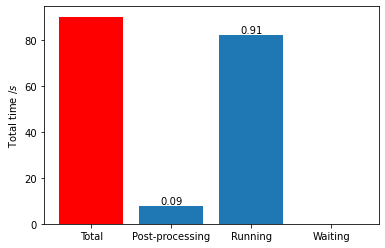

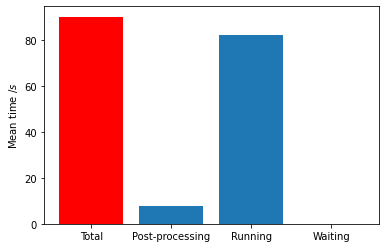

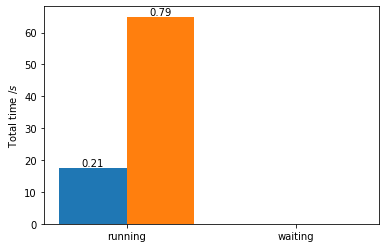

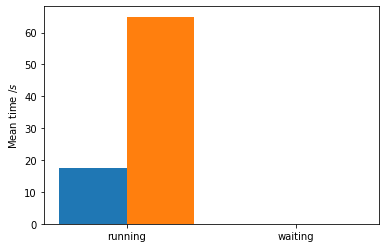

In [21]:
analyze_times(example_name, raw_data='raw_data.pkl');